In [1]:
import cv2
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import shift
import skfuzzy.control as ctrl
%matplotlib inline  
%autosave 120
try:
    import vrep
except:
    print ('--------------------------------------------------------------')
    print ('"vrep.py" could not be imported. This means very probably that')
    print ('either "vrep.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "vrep.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
from IPython.display import clear_output
from IPython.display import display
import ctypes 

Autosaving every 120 seconds


## load the saved image

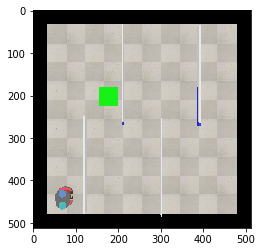

In [2]:
img = cv2.imread("grid_with_orientation.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
%matplotlib inline
plt.imshow(img)
plt.show()

## Obstacle thresholding 


In [3]:
def obstacles_grid(img):
    # getting the walls 
    mask_wall_r = cv2.inRange(img[:,:,0], 230,240)
    mask_wall_g = cv2.inRange(img[:,:,1], 230,240)
    mask_wall_b = cv2.inRange(img[:,:,0], 230,240)
    mask_wall = cv2.bitwise_and(mask_wall_r,mask_wall_g,mask_wall_b)
#     print(mask_wall.shape)
    # getting the rims
    mask_rim = cv2.inRange(img, 0, 0)
#     print(mask_rim.shape)
    mask_total = cv2.bitwise_or(mask_wall,mask_rim,mask_rim)
    mask_total = cv2.bitwise_not(mask_total)
    return mask_total

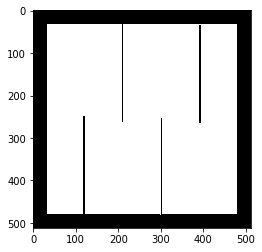

In [4]:
img_obs = obstacles_grid(img)
%matplotlib inline
plt.imshow(img_obs, cmap="gray")
plt.show()

## Robot position thresholding

In [5]:
def get_robot_position(img):
    robot_mask = cv2.inRange(img, np.array([100,100,100]), np.array([110,110,110]))
    robot_mask = cv2.GaussianBlur(robot_mask, (9, 9), 0)
    im2, contours, hierarchy = cv2.findContours(robot_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

    return robot_mask, (cY,cX)    

(438, 72)


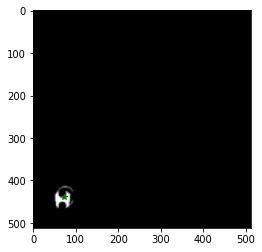

In [6]:
img_robot, center_robot = get_robot_position(img)
print(center_robot)
%matplotlib inline
plt.imshow(img_robot, cmap="gray")
plt.plot(center_robot[1],center_robot[0], "*g")
plt.show()

In [7]:
%matplotlib inline
def get_front_disk_position (img):
    front_disk_mask = cv2.inRange(img, np.array([100,140,205]), np.array([105,145,210]))
    im2, contours, hierarchy = cv2.findContours(front_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    return np.array([cY,cX])

def get_back_disk_position (img):
    rear_disk_mask = cv2.inRange(img, np.array([75,185,185]), np.array([80,190,190]))    
    im2, contours, hierarchy = cv2.findContours(rear_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    return np.array([cY,cX])
def get_robot_orientation(img):
    front_disk_position = get_front_disk_position (img)
    rear_disk_position =  get_back_disk_position (img)
    orientation = np.arctan2(rear_disk_position[1]-front_disk_position[1] , rear_disk_position[0]-front_disk_position[0])
    return orientation

In [8]:
orient = get_robot_orientation(img)
print(orient)

0.0


In [9]:
def get_robot_position(img):
    front_disk_position = get_front_disk_position (img)
    rear_disk_position =  get_back_disk_position (img)
    robot_pos = (front_disk_position+rear_disk_position)/2
#     print(robot_pos)
    return tuple(robot_pos.astype('int'))

(445, 68)


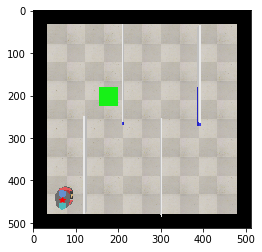

In [10]:
center_robot = get_robot_position(img)
print(center_robot)
%matplotlib inline
plt.imshow(img)
plt.plot(center_robot[1],center_robot[0], "*r")
plt.show()

## Goal thresholding

In [11]:
def get_goal_position(img):
    goal_mask = cv2.inRange(img[:,:,1], 240, 255)
    goal_mask = cv2.GaussianBlur(goal_mask, (9, 9), 0)
    im2, contours, hierarchy = cv2.findContours(goal_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

    return goal_mask, (cY,cX)

(202, 177)


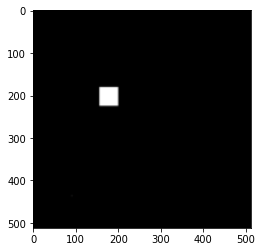

In [12]:
img_goal, center_goal = get_goal_position(img)
print(center_goal)
%matplotlib inline
plt.imshow(img_goal, cmap="gray")
plt.show()

## A* planning


In [13]:
def search(grid,init,goal,cost, D = 1, fnc='Euclidean', D2 = 1):
    
    def Euclidean_fnc(current_indx, goal_indx,D = 1):
        return np.sqrt( ( (current_indx[0]-goal_indx[0])**2 + (current_indx[1]-goal_indx[1])**2 ) )
    def Manhattan_fnc(current_indx, goal_indx,D = 1):
        dx = np.sqrt((current_indx[0]-goal_indx[0])**2)
        dy = np.sqrt((current_indx[1]-goal_indx[1])**2)
        return D * (dx + dy)
    def Diagonal_fnc(current_indx, goal_indx,D = 1):
        dx = np.sqrt((current_indx[0]-goal_indx[0])**2)
        dy = np.sqrt((current_indx[1]-goal_indx[1])**2)
        return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy) 
    
    if fnc=='Euclidean':
        hueristic_fnc = Euclidean_fnc
    elif fnc == "Manhattan":
        hueristic_fnc = Manhattan_fnc
    elif fnc == "Diagonal" :
        hueristic_fnc = Diagonal_fnc
    
    
    def near_obstacles(point, half_kernel = 5):
        x_start = int(max(point[0] - half_kernel, 0))
        x_end = int(min(point[0] + half_kernel, grid.shape[0]))
        y_start = int(max(point[1] - half_kernel, 0))
        y_end = int(min(point[1] + half_kernel, grid.shape[1]))
        return np.any(grid[x_start:x_end, y_start:y_end]<128)
    
    def delta_gain(gain = 1):
        delta = np.array([[-1, 0], # go up
                          [-1,-1], # up left
                          [ 0,-1], # go left
                          [ 1,-1], # down left
                          [ 1, 0], # go down
                          [ 1, 1],  # down right
                          [ 0, 1], # go right         
                          [-1, 1] # up right         
         ]) 
        return delta*gain
    
    delta = delta_gain(gain = 5)
    front = PriorityQueue()
    G = 0
    H = hueristic_fnc(init, goal, D)
    F = G+H
    front.put((F, G, init))
    discovered = []
    discovered.append(init)
    
    actions = np.ones_like(grid)*-1
#     expand = np.ones_like(grid)*-1
#     expand[0,0] = 0
    count = 0
    path = []
    
    def policy_draw(indx):
        indx_old = tuple(indx)
        indx_new = tuple(indx)
        path.append(tuple(goal))
        while indx_new != init:
            indx_new = tuple( np.array(indx_old) - delta[int(actions[indx_old])] )
            path.append(indx_new)
            indx_old = indx_new
    
        
    while not front.empty() :
        front_element = front.get()
        G = front_element[1]
        indx = front_element[2]
        if ((indx[0] >= goal[0]-20) and (indx[0] < goal[0]+20)) and ((indx[1] >= goal[1]-20) and (indx[1] < goal[1]+20)):
            policy_draw(indx)
            print("found goal")
            print(count)
            print(front_element)
            break 
        else:
            for y in range(len(delta)) :
                indx_new = tuple(indx + delta[y])

                if ((np.any(np.array(indx_new) < 0)) or (indx_new[0] > grid.shape[0]-1) or (indx_new[1] > grid.shape[1]-1)) :
                    continue
                if (grid[indx_new] >= 128) and (indx_new not in  discovered) :
                    count += 1
                    if near_obstacles(indx_new, half_kernel = 35):
                        g_new = G + 1500*cost
                    elif near_obstacles(indx_new, half_kernel = 70):
                        g_new = G + 15*cost
                    elif near_obstacles(indx_new, half_kernel = 100):
                        g_new = G + 10*cost
                    elif near_obstacles(indx_new, half_kernel = 110):
                        g_new = G + 5*cost
                    else:
                        g_new = G + cost
                    if y == actions[indx]:
                        g_new = g_new 
                    elif (y-1)%len(delta) == actions[indx] or (y+1)%len(delta) == actions[indx]:
                        g_new = g_new + 5*cost
                    else :
                        g_new = g_new + 10*cost
                    h_new = hueristic_fnc(indx_new, goal, D)
                    f_new = (g_new + h_new)-0.0001*count
                    front.put((f_new, g_new, indx_new))
                    discovered.append(indx_new)
                    actions[indx_new] = y
#                     expand[indx_new] = count
        
    else:
        print(count)
        print("fail")
                
                
    return actions, np.array(path[::-1])

In [14]:
tick = time.time()
actions, path = search(img_obs,center_robot,center_goal,cost = 1, D = 0.5, fnc='Diagonal')
tock = time.time()
print(tock-tick)

found goal
446
(937.9575, 925, (195, 158))
0.06367015838623047


## Path smoothing

In [15]:
def smooth(path,grid, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001, number_of_iter = 1e3):
    newpath = np.copy(path).astype('float64')
    def get_near_obstacles(point, area = 5):
#         print(point)
        x_start = int(max(point[0] - area, 0))
        x_end = int(point[0] + area)
        y_start = int(max(point[1] - area, 0))
        y_end = int(point[1] + area)
        points = np.argwhere(grid[x_start:x_end, y_start:y_end]<128)
        points [:,0] += x_start
        points [:,1] += y_start
        if not points.size:
            points = point.copy()
        return points
    
    def near_obstacles(point, half_kernel = 2):
        x_start = int(max(point[0] - half_kernel, 0))
        x_end = int(point[0] + half_kernel)
        y_start = int(max(point[1] - half_kernel, 0))
        y_end = int(point[1] + half_kernel)
        return np.any(grid[x_start:x_end, y_start:y_end]<128)
        
    error = np.ones(path.shape[0])*tolerance+tolerance
    num_points = path.shape[0]
    for count in range(int(number_of_iter)):
        for i in range(1,num_points-1):
            old_val = np.copy(newpath[i])
            update1 = weight_data*(path[i] - newpath[i])
            update2 = weight_smooth*(newpath[i-1]+newpath[i+1]-2*newpath[i])
            newpath[i]+=update1+update2 
            if near_obstacles(newpath[i], half_kernel = 35):
                newpath[i] = old_val
            error[i] = np.abs(np.mean(old_val-newpath[i]))
        if np.mean(error) < tolerance:
            break
    print(count)
    return newpath 

In [16]:
newpath = smooth(path,img_obs, weight_data = 0.1, weight_smooth = 0.6, number_of_iter = 1000)

35


## Plotting everything

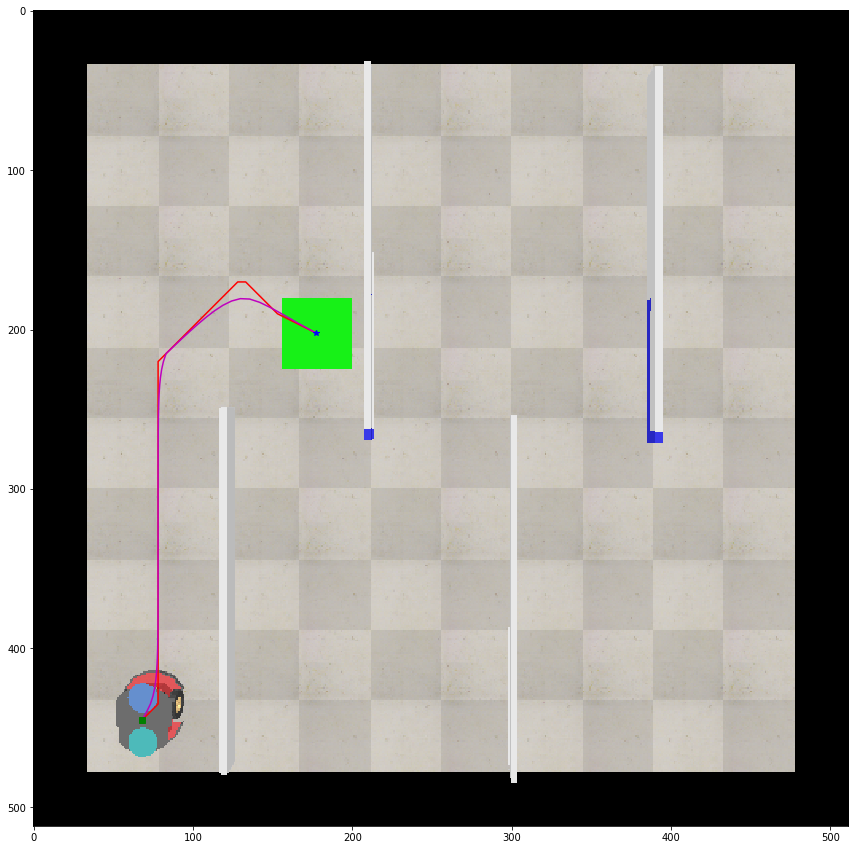

In [17]:
%matplotlib inline
fig1 = plt.figure(figsize=(15, 15))  
# plt.imshow(img_obs, cmap="gray")
plt.imshow(img)
plt.plot(path[:,1], path[:,0],'-r')
plt.plot(newpath[:,1], newpath[:,0],'-m')
# plt.plot(yp, xp,'-b')
plt.plot(center_goal[1], center_goal[0], '*b')
plt.plot(center_robot[1], center_robot[0], 'sg')
# plt.plot(newpath[11,1],newpath[11,0], '*r')
plt.show()
fig1.savefig('Astar_smooth_vrep.png', dpi=150)

## Some helping functions
1. tranform points from image space to "real" space
2. send path to be drawn
3. robot model
4. transform to robot frame of refrence
5. check if a point is near the robot within a distance
6. calulate the dostance between the robot and a point
7. PID class

In [18]:
def transform_points_from_image2real (points):
    if points.ndim < 2:
        flipped = np.flipud(points)
    else:
        flipped = np.fliplr(points)
    scale = 5/445
    points2send = (flipped*-scale) + np.array([2.0555+0.75280899, -2.0500+4.96629213])
    return points2send

In [19]:
def send_path_4_drawing(path, sleep_time = 0.07):
    for i in path:
        point2send = transform_points_from_image2real (i)
        packedData=vrep.simxPackFloats(point2send.flatten())
        raw_bytes = (ctypes.c_ubyte * len(packedData)).from_buffer_copy(packedData)	
        returnCode=vrep.simxWriteStringStream(clientID, "path_coord", raw_bytes, vrep.simx_opmode_oneshot)
#         print("returnCode", returnCode)
#         print("point sent, ", point2send)
        time.sleep(sleep_time)
    

In [20]:
def transform2robot_frame(pos, point, theta):
    pos = np.asarray(pos)
    point = np.asarray(point)
    T_matrix = np.array([
            [np.sin(theta), np.cos(theta)],
            [np.cos(theta), -1*np.sin(theta)],
            ])
    trans = point-pos
    if trans.ndim >= 2:
        trans = trans.T
        point_t = np.dot(T_matrix, trans).T
    else:
        point_t = np.dot(T_matrix, trans)
    return point_t

In [21]:
def is_near(robot_center, point, dist_thresh = 2):
    dist = np.sqrt((robot_center[0]-point[0])**2 + (robot_center[1]-point[1])**2)
    return dist<=dist_thresh

def distance (robot_center, point):
    dist = np.sqrt((robot_center[0]-point[0])**2 + (robot_center[1]-point[1])**2)
    return dist

In [22]:
def get_slope(p1, p2):
    return (p2[1]-p1[1])/(p2[0]-p1[0])
def get_c (p1, slope):
    return p1[1] - slope*p1[0]
def lin_func(x,slope,c):
    return slope*x + c
def interpolate (p1,p2, n_of_points):
    m = get_slope(p1, p2)
    c = get_c (p1, m)
    x = np.linspace(p1[0],p2[0], n_of_points)
    y = lin_func(x,m,c)
    return np.array([x,y]).T
def interpolate_x(x, p1,p2):
    m = get_slope(p1, p2)
    c = get_c (p1, m)
    y = lin_func(x,m,c)
    return y

    
inter = interpolate_x(20,[100,100],[10,10])
print(inter)    

20.0


In [23]:
def get_distance(points1, points2):
    return np.sqrt(np.sum(np.square(points1 - points2), axis=1))
# def get_smallest_2(arr):
#     small_indx = np.argmin(arr)
#     if arr[small_indx+1] <  arr[small_indx+2]:
#         return (small_indx, small_indx+1)
#     else:
#         return (small_indx-1, small_indx)

def get_smallest_2(arr):
    small_indx = np.argmin(arr)
    if arr[small_indx+1,0] *arr[small_indx+2,0]:
        return (small_indx, small_indx+1)
    else:
        return (small_indx-1, small_indx)

## Robot Model

In [24]:
d = 0.331 #wheel axis distance
r_w = 0.09751 #wheel radius

In [25]:
def pioneer_robot_model(v_des, omega_des):
#     d = 0.331
    v_r = (v_des+d*omega_des)
    v_l = (v_des-d*omega_des)
#     r_w = 0.09751 #wheel radius
    omega_right = v_r/r_w
    omega_left = v_l/r_w
    return omega_right, omega_left

In [26]:
# https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/differential_drive_dynamics.py
def apply_dynamics(v_l, v_r, d_t, pose ):                       
    
    # calculate the change in wheel angle (in radians)
    d_angle_left  = d_t *-1* v_l
    d_angle_right = d_t * -1*v_r

    # calculate the distance traveled
    wheel_meters_per_rad = r_w
    d_left_wheel = d_angle_left * wheel_meters_per_rad
    d_right_wheel = d_angle_right * wheel_meters_per_rad
    d_center = ( d_left_wheel + d_right_wheel ) / 2.0

    # calculate the new pose
    old_x, old_y, old_theta = pose
    new_x = old_x + ( d_center * np.cos( old_theta ) )
    new_y = old_y + ( d_center * np.sin( old_theta ) )
    new_theta = old_theta + ( ( d_right_wheel - d_left_wheel ) / d )
    new_theta = np.arctan2(np.sin(new_theta), np.cos(new_theta))
    return [new_x,  new_y, new_theta]

## Doing everything live

In [27]:
class pid():
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.error = 0.0
        self.error_old = 0.0
        self.error_sum = 0.0
        self.d_error = self.error - self.error_old
    def control(self,error):
        self.error = error
        self.error_sum += error
        self.d_error = self.error - self.error_old
        P = self.kp*self.error
        I = self.ki*self.error_sum
        D = self.kd*self.d_error
        self.error_old = self.error
        return P+I+D
    def reset_integral_and_diff(self):
        self.error_old = 0.0
        self.error_sum = 0.0        

In [36]:
offset_2_delete = 5
lad = 0.5
print ('Starting Connection')
vrep.simxFinish(-1) # just in case, close all opened connections
clientID=vrep.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to V-REP
print(clientID)

if clientID!=-1:
    print ('Connected to remote API server')  
    e = vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
    print('start',e)
    try:
        res,camera0_handle = vrep.simxGetObjectHandle(clientID,'top_view_camera',vrep.simx_opmode_oneshot_wait)
        res_l,right_motor_handle = vrep.simxGetObjectHandle(clientID,'Pioneer_p3dx_rightMotor',vrep.simx_opmode_oneshot_wait)
        res_r,left_motor_handle = vrep.simxGetObjectHandle(clientID,'Pioneer_p3dx_leftMotor',vrep.simx_opmode_oneshot_wait)
        res_las,look_ahead_sphere = vrep.simxGetObjectHandle(clientID,'look_ahead',vrep.simx_opmode_oneshot_wait)
        indx = 0
        err = 10 #to make a knida do while out of while
        theta = 0.0
        dt = 0.0
        count = 0
        cte = 0
        old_cte = 0
        d_cte = cte - old_cte
        om_sp = 0
        d_controller   = pid(kp=0.5, ki=0, kd=0)
        omega_controller = pid(0.5, 0., 0.)
        while err != vrep.simx_return_ok:
            tick = time.time()
            errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
            errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
            err,resolution,image=vrep.simxGetVisionSensorImage(clientID,camera0_handle,0,vrep.simx_opmode_streaming)  
            if err == vrep.simx_return_ok:
                img = np.array(image,dtype=np.uint8)
                img.resize([resolution[1],resolution[0],3])
                img_obs = obstacles_grid(img)
                center_robot = get_robot_position(img)
#                 center_robot = transform_points_from_image2real(np.array(center_robot))
                img_goal, center_goal = get_goal_position(img)
#                 center_goal = transform_points_from_image2real(np.array(center_goal))
                _ , path = search(img_obs,center_robot,center_goal,cost = 1, D = 1 , fnc='Manhattan')
                newpath = smooth(path,img_obs, weight_data = 0.1, weight_smooth = 0.65, number_of_iter = 1000)                
                path_to_track = transform_points_from_image2real(newpath)
                tock = time.time()                
                dt = tock - tick
                print("planning takes : ", dt)
                send_path_4_drawing(newpath, 0.05)
                center_goal = transform_points_from_image2real(np.array(center_goal))
        while not is_near(center_robot, center_goal, dist_thresh = 0.25):            
            tick = time.time()
            err,resolution,image=vrep.simxGetVisionSensorImage(clientID,camera0_handle,0,vrep.simx_opmode_streaming)        
            if err == vrep.simx_return_ok:
                img = np.array(image,dtype=np.uint8)
                img.resize([resolution[1],resolution[0],3])
                center_robot = get_robot_position(img)
                center_robot = transform_points_from_image2real(np.array(center_robot))
                theta = get_robot_orientation(img)
                theta = np.arctan2(np.sin(theta), np.cos(theta))
                path_transformed = transform2robot_frame(center_robot, path_to_track, theta)
                dist = get_distance(path_transformed, np.array([0,0]))
                for i in range(dist.argmin(), dist.shape[0]):
                    if dist[i] < lad and indx <= i:
                        indx = i
#                     else:
#                         break
                returnCode=vrep.simxSetObjectPosition(clientID,look_ahead_sphere,-1,(path_to_track[indx,0], path_to_track[indx,1], 0.005),vrep.simx_opmode_oneshot)
#                 print(indx, path_transformed[indx], dist[indx])
                orient_error = np.arctan2(path_transformed[indx,1], path_transformed[indx,0])
                v_sp = d_controller.control(dist[indx])                     
                om_sp =omega_controller.control(orient_error)
                vr, vl = pioneer_robot_model(v_sp, om_sp)
                errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, vr, vrep.simx_opmode_oneshot)
                errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,vl, vrep.simx_opmode_oneshot)
                count += 1
                old_cte = cte
    
                tock = time.time()                
                dt = tock - tick
#                 print(dt)
        else:
            print("GOAAAAAAALL !!")
            errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
            errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
    finally:
        errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
        errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
        time.sleep(0.1)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
        vrep.simxFinish(-1)


Starting Connection
0
Connected to remote API server
start 0
found goal
3741
(4486.6265, 4470, (146, 432))
29
planning takes :  1.984431505203247
GOAAAAAAALL !!


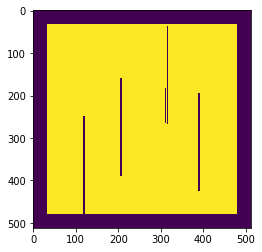

(<matplotlib.image.AxesImage at 0x1f2459afe10>, None)

In [29]:
plt.imshow(img_obs), plt.show()

In [37]:
!ls *.mp4

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [40]:
cap = cv2.VideoCapture('recording_2018_04_13-17_26-10.mp4')
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.mp4',fourcc, 60.0, (1696,864))

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )
count = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    out.write(frame)
    count+=1
    print(count, end=',')

cap.release()
out.release()

1205


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111

,3572,3573,3574,3575,3576,3577,3578,3579,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599,3600,3601,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611,3612,3613,3614,3615,3616,3617,3618,3619,3620,3621,3622,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649,3650,3651,3652,3653,3654,3655,3656,3657,3658,3659,3660,3661,3662,3663,3664,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674,3675,3676,3677,3678,3679,3680,3681,3682,3683,3684,3685,3686,3687,3688,3689,3690,3691,3692,3693,3694,3695,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705,3706,3707,3708,3709,3710,3711,3712,3713,3714,3715,3716,3717,3718,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771

,5241,5242,5243,5244,5245,5246,5247,5248,5249,5250,5251,5252,5253,5254,5255,5256,5257,5258,5259,5260,5261,5262,5263,5264,5265,5266,5267,5268,5269,5270,5271,5272,5273,5274,5275,5276,5277,5278,5279,5280,5281,5282,5283,5284,5285,5286,5287,5288,5289,5290,5291,5292,5293,5294,5295,5296,5297,5298,5299,5300,5301,5302,5303,5304,5305,5306,5307,5308,5309,5310,5311,5312,5313,5314,5315,5316,5317,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327,5328,5329,5330,5331,5332,5333,5334,5335,5336,5337,5338,5339,5340,5341,5342,5343,5344,5345,5346,5347,5348,5349,5350,5351,5352,5353,5354,5355,5356,5357,5358,5359,5360,5361,5362,5363,5364,5365,5366,5367,5368,5369,5370,5371,5372,5373,5374,5375,5376,5377,5378,5379,5380,5381,5382,5383,5384,5385,5386,5387,5388,5389,5390,5391,5392,5393,5394,5395,5396,5397,5398,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408,5409,5410,5411,5412,5413,5414,5415,5416,5417,5418,5419,5420,5421,5422,5423,5424,5425,5426,5427,5428,5429,5430,5431,5432,5433,5434,5435,5436,5437,5438,5439,5440

,6926,6927,6928,6929,6930,6931,6932,6933,6934,6935,6936,6937,6938,6939,6940,6941,6942,6943,6944,6945,6946,6947,6948,6949,6950,6951,6952,6953,6954,6955,6956,6957,6958,6959,6960,6961,6962,6963,6964,6965,6966,6967,6968,6969,6970,6971,6972,6973,6974,6975,6976,6977,6978,6979,6980,6981,6982,6983,6984,6985,6986,6987,6988,6989,6990,6991,6992,6993,6994,6995,6996,6997,6998,6999,7000,7001,7002,7003,7004,7005,7006,7007,7008,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048,7049,7050,7051,7052,7053,7054,7055,7056,7057,7058,7059,7060,7061,7062,7063,7064,7065,7066,7067,7068,7069,7070,7071,7072,7073,7074,7075,7076,7077,7078,7079,7080,7081,7082,7083,7084,7085,7086,7087,7088,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120,7121,7122,7123,7124,7125

,8598,8599,8600,8601,8602,8603,8604,8605,8606,8607,8608,8609,8610,8611,8612,8613,8614,8615,8616,8617,8618,8619,8620,8621,8622,8623,8624,8625,8626,8627,8628,8629,8630,8631,8632,8633,8634,8635,8636,8637,8638,8639,8640,8641,8642,8643,8644,8645,8646,8647,8648,8649,8650,8651,8652,8653,8654,8655,8656,8657,8658,8659,8660,8661,8662,8663,8664,8665,8666,8667,8668,8669,8670,8671,8672,8673,8674,8675,8676,8677,8678,8679,8680,8681,8682,8683,8684,8685,8686,8687,8688,8689,8690,8691,8692,8693,8694,8695,8696,8697,8698,8699,8700,8701,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711,8712,8713,8714,8715,8716,8717,8718,8719,8720,8721,8722,8723,8724,8725,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738,8739,8740,8741,8742,8743,8744,8745,8746,8747,8748,8749,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762,8763,8764,8765,8766,8767,8768,8769,8770,8771,8772,8773,8774,8775,8776,8777,8778,8779,8780,8781,8782,8783,8784,8785,8786,8787,8788,8789,8790,8791,8792,8793,8794,8795,8796,8797

,10221,10222,10223,10224,10225,10226,10227,10228,10229,10230,10231,10232,10233,10234,10235,10236,10237,10238,10239,10240,10241,10242,10243,10244,10245,10246,10247,10248,10249,10250,10251,10252,10253,10254,10255,10256,10257,10258,10259,10260,10261,10262,10263,10264,10265,10266,10267,10268,10269,10270,10271,10272,10273,10274,10275,10276,10277,10278,10279,10280,10281,10282,10283,10284,10285,10286,10287,10288,10289,10290,10291,10292,10293,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303,10304,10305,10306,10307,10308,10309,10310,10311,10312,10313,10314,10315,10316,10317,10318,10319,10320,10321,10322,10323,10324,10325,10326,10327,10328,10329,10330,10331,10332,10333,10334,10335,10336,10337,10338,10339,10340,10341,10342,10343,10344,10345,10346,10347,10348,10349,10350,10351,10352,10353,10354,10355,10356,10357,10358,10359,10360,10361,10362,10363,10364,10365,10366,10367,10368,10369,10370,10371,10372,10373,10374,10375,10376,10377,10378,10379,10380,10381,10382,10383,10384,10385,10386,103

KeyboardInterrupt: 

In [41]:
cap.release()
out.release()